# **Rastreamento de objetos com Fluxo Ótico**

#### **Iremos aprender:**
1. Como utilizar o Optical Flow no OpenCV
2. E quando usar o Dense Optical Flow

In [2]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import numpy as np
from matplotlib import pyplot as plt
#from google.colab.patches import cv2_imshow

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

!wget https://github.com/rajeevratan84/ModernComputerVision/raw/main/walking_short_clip.mp4
!wget https://github.com/rajeevratan84/ModernComputerVision/raw/main/walking.avi

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


## ** O Algoritmo de Optical Flow Lucas-Kanade **

O fluxo óptico é o padrão de movimento aparente de objetos de imagem entre dois quadros consecutivos causado pelo movimento do objeto ou da câmera. É um campo vetorial 2D onde cada vetor é um vetor de deslocamento que mostra o movimento dos pontos do primeiro para o segundo quadro. Considere a imagem abaixo (imagem cortesia: artigo da Wikipedia sobre fluxo óptico).


![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Optical_flow_example_v2.png/440px-Optical_flow_example_v2.png)

Mostra uma bola se movendo em 5 quadros consecutivos. A seta mostra seu vetor deslocamento. O fluxo óptico tem muitas aplicações em áreas como:

- Structure from Motion
- Video Compression
- Video Stabilization

O fluxo óptico funciona com base em várias suposições:

- As intensidades de pixel de um objeto não mudam entre quadros consecutivos.
- Pixels vizinhos têm movimento semelhante.

Learn more - https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html

Para lidar com movimentos maiores, o algoritmo pode ser combinado com uma abordagem de pirâmide de imagens. Nesse caso, imagens em diferentes resoluções são analisadas, começando da mais baixa para a mais alta, acumulando os deslocamentos gradualmente.

**cv2.calcOpticalFlowPyrLK**

Função: cv2.calcOpticalFlowPyrLK é usada para calcular o fluxo óptico entre dois quadros consecutivos de um vídeo ou duas imagens. O fluxo óptico mede o movimento aparente de pixels de um quadro para outro, o que é útil para rastreamento de objetos, estabilização de vídeo, e outras aplicações de visão computacional.

Parâmetros Principais
- prevImg: Imagem de entrada na primeira etapa (grayscale, por exemplo).
- nextImg: Imagem de entrada na segunda etapa, correspondente ao próximo quadro.
- prevPts: Conjunto de pontos (coordenadas 2D) na imagem anterior, geralmente fornecidos como um array numpy do tipo float32.

Retornos
- nextPts Coordenadas dos pontos na imagem do próximo quadro.
- status: Array de saída indicando se o ponto foi encontrado no próximo quadro (1 para encontrado, 0 caso contrário).
- err: Array que retorna os erros de reprojeção para cada ponto.


Fundamentação matemática:

O algoritmo baseia-se na suposição de que o fluxo óptico segue dois princípios:

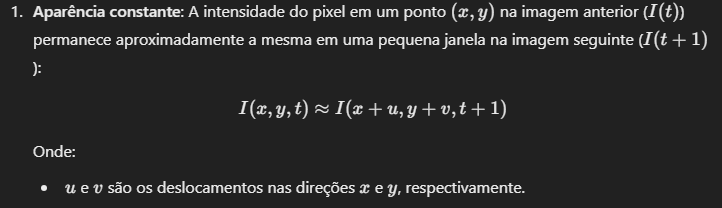

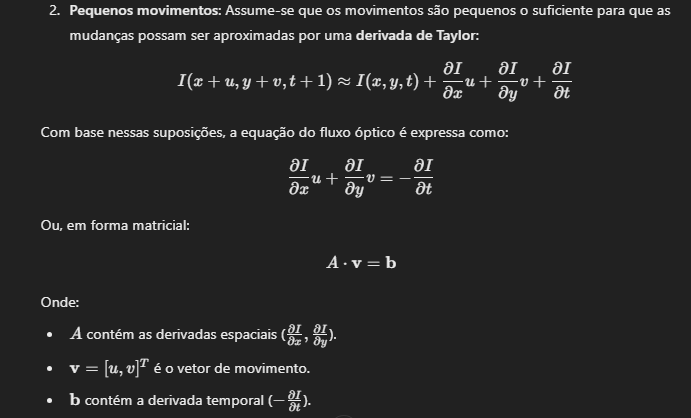

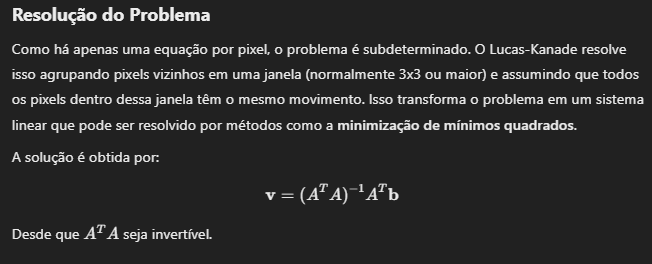




In [8]:
# Load video stream, short clip
#cap = cv2.VideoCapture('walking_short_clip.mp4')

# Load video stream, long clip
cap = cv2.VideoCapture('images/pessoa.mp4')

# Get the height and width of the frame (required to be an interger)
width = int(cap.get(3)) 
height = int(cap.get(4))

# Define the codec and create VideoWriter object. The output is stored in '*.avi' file.
out = cv2.VideoWriter('optical_flow_pessoa.avi', cv2.VideoWriter.fourcc('M','J','P','G'), 30, (width, height))

# Set parameters for ShiTomasi Detector de cantos
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Definir parâmetros para o fluxo óptico de Lucas Kanade
lucas_kanade_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Criando algumas cores randoms
# Usado para criar nossas trilhas para movimento de objetos na imagem
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Find inital corner locations
prev_corners = cv2.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)

# Crie uma imagem de máscara para fins de desenho
mask = np.zeros_like(prev_frame)

while(1):
    ret, frame = cap.read()

    if ret == True:
      frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

      # calculate optical flow
      new_corners, status, errors = cv2.calcOpticalFlowPyrLK(prev_gray, 
                                                            frame_gray, 
                                                            prev_corners, 
                                                            None, 
                                                            **lucas_kanade_params)

      # Select and store good points
      good_new = new_corners[status==1]
      good_old = prev_corners[status==1]

      # Draw the tracks
      for i,(new,old) in enumerate(zip(good_new, good_old)):
          a, b = new.ravel()
          c, d = old.ravel()
          mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
          frame = cv2.circle(frame, (int(a),int(b)), 5, color[i].tolist(),-1)
          
      img = cv2.add(frame,mask)

      # Save Video
      out.write(img)
      # Show Optical Flow
      #imshow('Optical Flow - Lucas-Kanade',img)

      # Now update the previous frame and previous points
      prev_gray = frame_gray.copy()
      prev_corners = good_new.reshape(-1,1,2)

    else:
      break
    
cap.release()
out.release()

In [3]:
!ffmpeg -i /content/optical_flow_walking.avi optical_flow_walking.mp4 -y

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [4]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('optical_flow_walking.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [5]:
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

**NOTE**

Este código não verifica quão corretos são os próximos pontos-chave. Portanto, mesmo que algum ponto característico desapareça na imagem, há uma chance de que o fluxo óptico encontre o próximo ponto que possa parecer próximo dele. Então, na verdade, para um rastreamento robusto, os pontos de canto devem ser detectados em intervalos específicos

### **Dense Optical Flow**

O método Lucas-Kanade calcula o fluxo óptico para um conjunto de recursos esparsos (em nosso exemplo, cantos detectados usando o algoritmo Shi-Tomasi). OpenCV fornece outro algoritmo para encontrar o fluxo óptico denso. Ele calcula o fluxo óptico para todos os pontos do quadro. É baseado no algoritmo de Gunner Farneback, que é explicado em “[Two-Frame Motion Estimation Based on Polynomial Expansion](https://www.researchgate.net/publication/225138825_Two-Frame_Motion_Estimation_Based_on_Polynomial_Expansion)” by Gunner Farneback in 2003.

O exemplo abaixo mostra como encontrar o fluxo óptico denso usando o algoritmo acima. Obtemos uma matriz de 2 canais com vetores de fluxo óptico, (u,v). Encontramos sua magnitude e direção. Codificamos o resultado por cores para melhor visualização.

- Direction corresponds to Hue value of the image. 
- Magnitude corresponds to Value plane. See the code below:

Lembrando que HSV - 0(HUE), 1 (SATURATION) e 2 (VALUE)


Base Teórica
O fluxo óptico é a estimativa do movimento de padrões de intensidade em uma sequência de imagens. O algoritmo de Farnebäck resolve isso ajustando polinômios quadráticos locais em janelas de pixels para modelar mudanças entre dois quadros.

1. Modelo Polinomial Local
Em pequenas regiões de uma imagem, o padrão de intensidades pode ser modelado como uma função quadrática:

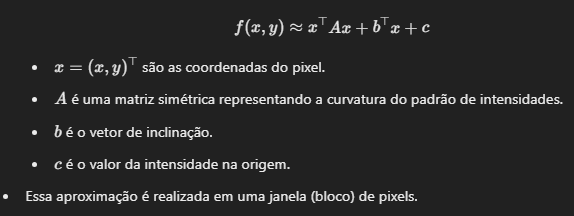

2. Deslocamento entre Quadros
Se um padrão em uma janela se move, o polinômio ajustado no quadro anterior será semelhante ao do quadro atual, mas deslocado. O objetivo do algoritmo é calcular esse deslocamento.

Etapas do Algoritmo
- Construção da Pirâmide de Imagens

    Para lidar com movimentos em diferentes escalas, o algoritmo cria uma pirâmide de imagens.
    Cada nível da pirâmide é uma versão reduzida (downsampled) do quadro original.
    Isso ajuda a capturar movimentos grandes em níveis inferiores e movimentos pequenos em níveis superiores.

- Ajuste de Polinômios

    Para cada pixel em um nível da pirâmide, ajusta-se um polinômio quadrático local para modelar o padrão de intensidades.

- Estimativa Inicial de Deslocamento

    Com base nos polinômios ajustados no quadro anterior e atual, o deslocamento inicial é estimado para cada pixel.

- Refinamento Iterativo

    A estimativa inicial é refinada iterativamente:

        O padrão de intensidade do quadro anterior é transformado de acordo com o deslocamento estimado.

        A diferença entre os quadros (resíduo) é minimizada ajustando novamente os polinômios.

    Este processo é repetido para todos os níveis da pirâmide.

-  Propagação de Fluxo

    A estimativa refinada em um nível da pirâmide é propagada para o próximo nível (com maior resolução).
    O processo é repetido até o nível original da imagem.

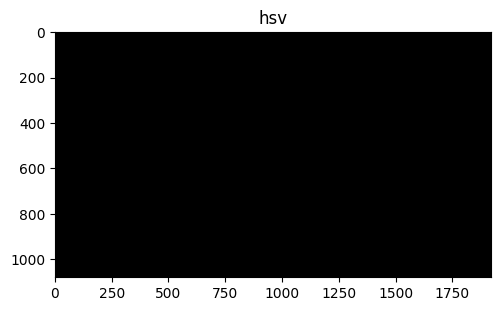

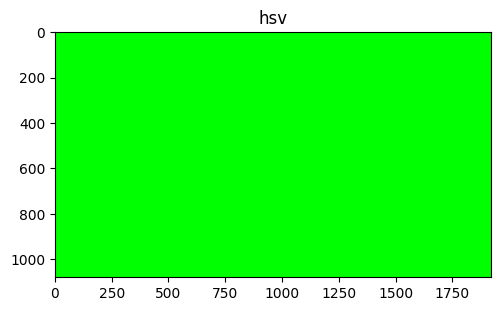

In [3]:
# Load video stream, short clip
#cap = cv2.VideoCapture('walking_short_clip.mp4')

# Carrega o vídeo
cap = cv2.VideoCapture('images/pessoa.mp4')

# Pegando as dimensões
width = int(cap.get(3)) 
height = int(cap.get(4))

# Criando o arquivo de saida
out = cv2.VideoWriter('dense_optical_flow_pessoa.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width, height))

# Pegando o primeiro frame
ret, first_frame = cap.read()
previous_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY) #Escala de cinza do primeiro frame
hsv = np.zeros_like(first_frame) #Criamos uma cópia de zeros
imshow('hsv',hsv)
hsv[...,1] = 255
imshow('hsv',hsv) #é verde pq a função só aceita BGR

while True:
    
    # ler o video
    ret, frame2 = cap.read()

    if ret == True:
      #convertendo o proximo frame para cinza
      next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

      # Computes the dense optical flow using the Gunnar Farneback’s algorithm
      # Passando o primeiro frame
      # Passando o segundo
      # Parametro Flow (opcional), para o cálculo com um fluxo estimado previamente. 
      # Parametro da piramide. Fator de escala entre níveis consecutivos da pirâmide de imagens (0 a 1).Valores menores permitem detectar movimentos maiores.
      # Parametro levels. Número de níveis na pirâmide de imagens. Controla a granularidade da análise (mais níveis ajudam em movimentos grandes).
      # Parametro da janela. Tamanho da janela usada para suavização (em pixels). Janelas maiores são mais robustas a ruído, mas podem perder detalhes.
      # Interações. Número de iterações por nível da pirâmide.
      # Parametro Poly_N. Tamanho da vizinhança usada para ajuste de polinômios. Pode ser 5 ou 7. Um valor maior captura movimentos mais suaves.
      # Desvio padrão do Gaussian usado para suavizar o ajuste de polinômios.

      #SAIDA: A função retorna um array flow com as mesmas dimensões da entrada, mas com dois canais
      #CANAL 0, DESLOCAMENTO NO EIXO X
      #CANAL 1, DESLOCAMENTO NO EIXTO Y

      flow = cv2.calcOpticalFlowFarneback(previous_gray, next, 
                                          None, 0.5, 3, 15, 3, 5, 1.2, 0)

      # use flow to calculate the magnitude (speed) and angle of motion
      # use these values to calculate the color to reflect speed and angle
      # CV2.CARTTOPOLAR, CONVERTE COORDENADAS CARTESIANAS PARA POLARES
      magnitude, angle = cv2.cartToPolar(flow[...,0], flow[...,1])
      # Convertendo o angulo em radianos numa escala de 0 - 180 (Lembrando, que HUE 0 - 179)
      hsv[...,0] = angle * (180 / (np.pi/2)) 
      # Normalizar a magnitude para escala de 0 (alpha - limite inferior) a 255 (beta - limite superior)
      # Lembrando que VALUE vai de 0 - 255
      hsv[...,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
      # Convertendo a imagem para BGR
      final = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
      cv2.imshow('Dense optical', final)
      cv2.waitKey(1) & 0xFF == ord('0')
      # Save Video
      out.write(final)
      # Show our demo of Dense Optical Flow
      #imshow('Dense Optical Flow', final)
      
      # Store current image as previous image
      previous_gray = next

    else:
      break
    
cv2.destroyAllWindows()
cap.release()
out.release()

In [7]:
!ffmpeg -i /content/dense_optical_flow_walking.avi dense_optical_flow_walking.mp4 -y

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [8]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('dense_optical_flow_walking.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [9]:
HTML("""
<video controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.